In [2]:
import scanpy as sc

In [3]:
# 设置参数
sc.settings.verbosity = 4
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=300,
    facecolor="white",
    frameon=False,  # remove frame
)

In [4]:
## 13.1 准备monocle3

In [5]:
## 13.1.1 读取注释后的数据
adata = sc.read("anndata_celltypist_anno.h5ad")

In [6]:
## 13.1.2 准备R环境
import anndata2ri
import logging 

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.CRITICAL) # 
ro.pandas2ri.activate() # type: ignore
anndata2ri.activate()

%load_ext rpy2.ipython 

/tmp/ipykernel_3344642/1117952461.py:10: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [7]:
## 13.2 准备变量
expression_matrix = adata.X.T
cell_metadata = adata.obs
gene_annotation = adata.var

In [8]:
%%R -i expression_matrix -i cell_metadata -i gene_annotation
## 13.3 从R中构建cds对象
library(monocle3)
# 必须要一列名为gene_short_name
gene_annotation$gene_short_name = rownames(gene_annotation)
cds <- new_cell_data_set(expression_matrix,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation
                         )

Loading required package: Biobase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required

Aligning cells from different batches using Batchelor.
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091


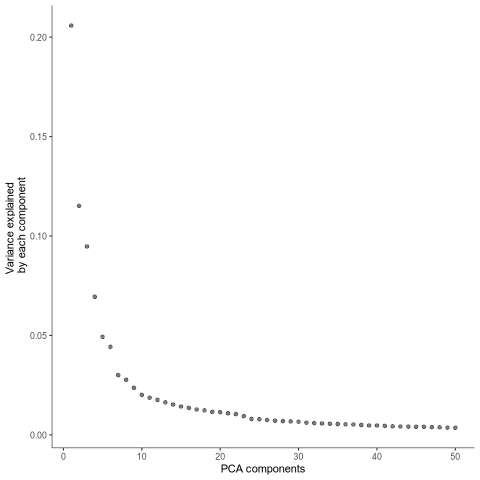

In [9]:
%%R
## 13.4预处理数据
cds <- preprocess_cds(cds, num_dim = 50)
cds <- align_cds(cds, alignment_group = "sample", residual_model_formula_str = "~ pct_counts_mt")
plot_pc_variance_explained(cds)

No preprocess_method specified, and aligned coordinates have been computed previously. Using preprocess_method = 'Aligned'
Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'
No trajectory to plot. Has learn_graph() been called yet?
No trajectory to plot. Has learn_graph() been called yet?


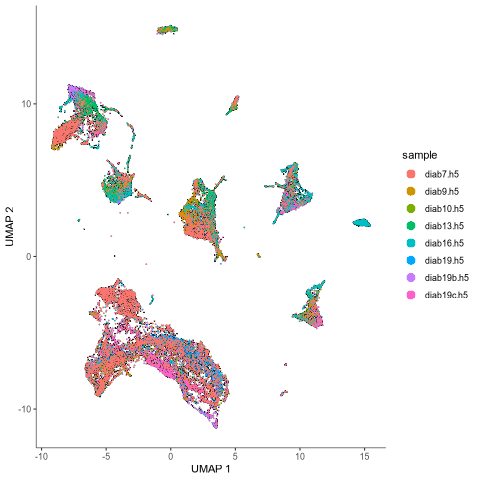

In [11]:
%%R
## 13.5降维、可视化
cds <- reduce_dimension(
    cds,
    # reduction_method = c("UMAP", "tSNE", "PCA", "LSI", "Aligned"),
    # 总之得先指定UMAP
    cores=20,# 用多少核心
    )
plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "leiden")
## 13.4.1 检查批次效应
plot_cells(cds, color_cells_by="sample", label_cell_groups=FALSE)

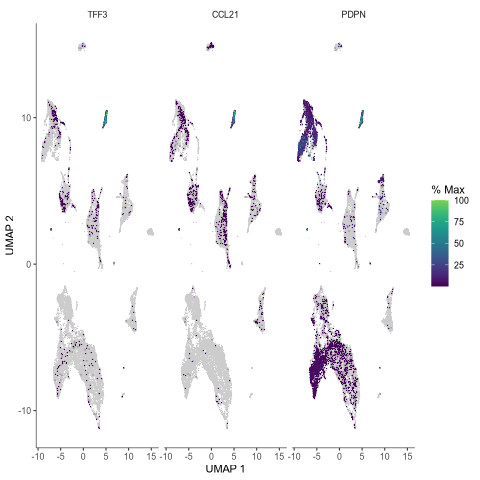

In [12]:
%%R
## 13.6 可视化单个基因如何沿着轨迹变化
ciliated_genes <- c("TFF3", "CCL21", "PDPN")

plot_cells(cds,
           genes=ciliated_genes,
           label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)

   resolution_parameter quality modularity significance cluster_count selected
                  1e-04 1032423  0.9019852     823103.3            19        *
   cluster cell_count cell_fraction
         1       3724         0.143
         2       3340         0.128
         3       3016         0.116
         4       2588         0.099
         5       2325         0.089
         6       2304         0.088
         7       1979         0.076
         8       1958         0.075
         9       1519         0.058
        10       1446         0.056
        11        561         0.022
        12        473         0.018
        13        453         0.017
        14        117         0.004
        15         77         0.003
        16         56         0.002
        17         54         0.002
        18         38         0.001
        19         23         0.001


set_nn_control: call stack: () => () => () => cluster_cells() => set_nn_control()
  nn_control: 
    method: annoy
    metric: euclidean
    n_trees: 50
    search_k: 2000
    cores: 1
    grain_size: 1
Running leiden clustering algorithm ...
Run kNN based graph clustering starts:
  -Input data of 26051 rows and 2 columns
  -k is set to 20
  Finding nearest neighbors...
set_nn_control: call stack: () => () => () => cluster_cells() => leiden_clustering() => cluster_cells_make_graph() => make_nn_index() => set_nn_control()
  nn_control: 
    method: annoy
    metric: euclidean
    n_trees: 50
    search_k: NA
    cores: NA
    grain_size: NA
make_nn_index:
  nn_control: 
    method: annoy
    metric: euclidean
    n_trees: 50
    search_k: NA
    cores: NA
    grain_size: NA
make_nn_index: build time 2.50 seconds.
set_nn_control: call stack: () => () => () => cluster_cells() => leiden_clustering() => cluster_cells_make_graph() => search_nn_index() => set_nn_control()
  nn_control: 
    m

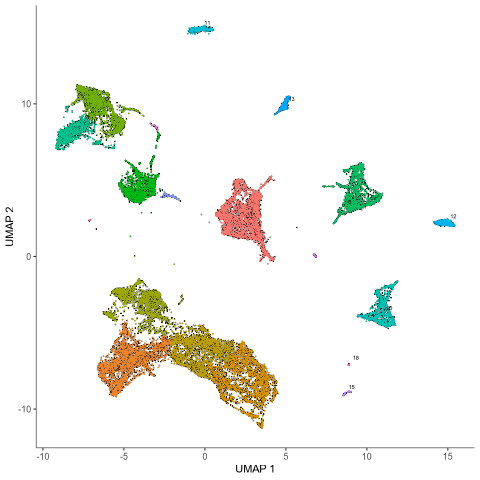

In [13]:
%%R
## 13.7 聚集细胞轨迹
cds <- cluster_cells(
    cds,
    verbose = TRUE
    ) 
plot_cells(cds, color_cells_by = "cluster", group_cells_by="partition")

  |======================================================================| 100%


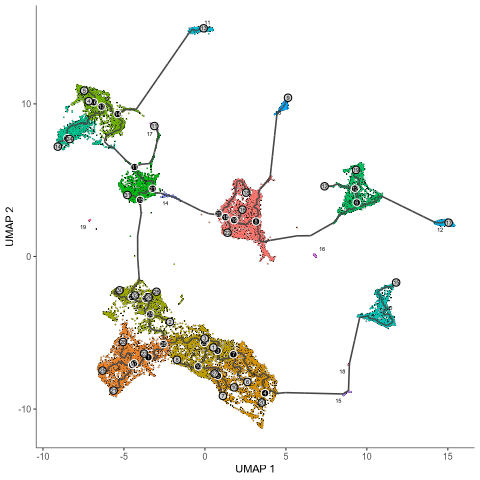

In [14]:
%%R
## 13.8 学习轨迹
cds <- learn_graph(
    cds, 
    use_partition = F # 不使用聚类结果,如果大多是灰的话
)
plot_cells(
    cds,
    color_cells_by = "cluster",
    label_groups_by_cluster=T,
    label_leaves=T,
    label_branch_points=T
    )

computing Diffusion Maps using n_comps=15(=n_dcs)
        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.998517   0.99846464 0.9976311  0.99667317 0.9964126
     0.99578285 0.99475926 0.99367774 0.9912819  0.98965204 0.9878251
     0.9850588  0.98234636 0.9781599 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)


/home/fanxi/mambaforge/envs/lang/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


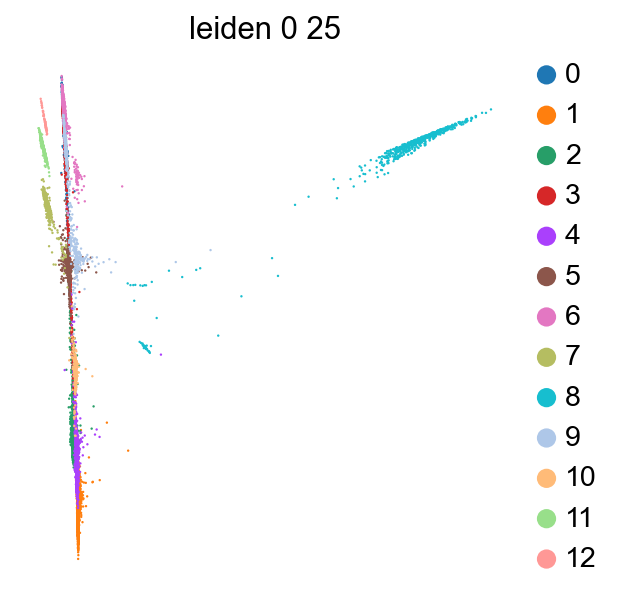

12910 ACTGTCCGTCCTCTTG-1_GSM7008847_diab9.h5


In [47]:
##  计算扩散伪时间（DPT）-我是为了找出根节点
sc.tl.diffmap(adata, random_state =123)
# Setting root cell as described above
root_ixs = adata.obsm["X_diffmap"][:, 3].argmin()
sc.pl.scatter(
    adata,
    basis="diffmap",
    color=["leiden_0_25"],
    components=[2, 3],
)

adata.uns["iroot"] = root_ixs
# 为了传给R,root_ixs是索引需要+1
root_ixs = root_ixs + 1
print(root_ixs, adata.obs_names[root_ixs])

In [48]:
%%R -i root_ixs
cds <- order_cells(
  cds,
  reduction_method = "UMAP",
#   root_pr_nodes = "Y_1",
  root_cells = colnames(cds)[root_ixs],
  verbose = True
)

cds$pseudotime <- cds@principal_graph_aux[["UMAP"]]$pseudotime[colnames(cds)]

In [ ]:
%%R
## 13.9 伪时间排序

# # 最好是上游提供"embryo.time.bin"
# plot_cells(
#     cds,
#     color_cells_by = "embryo.time.bin", 
#     label_cell_groups=FALSE,
#     label_leaves=TRUE,
#     label_branch_points=TRUE,
#     graph_label_size=1.5
#     )

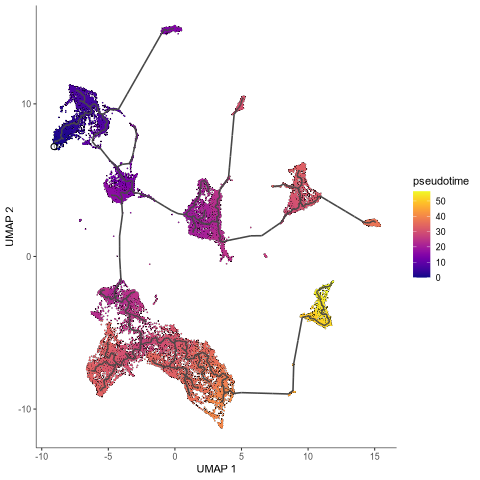

In [49]:
%%R
plot_cells(
    cds,
    color_cells_by = "pseudotime",
    label_cell_groups=FALSE,
    label_leaves=FALSE,
    label_branch_points=FALSE,
    graph_label_size=1.5
    )

In [ ]:
# %%R
# ## 一种自动找根节点的方法
# # a helper function to identify the root principal points:
# get_earliest_principal_node <- function(cds, time_bin="(4.34,8.68]"){
#   cell_ids <- which(colData(cds)[, "embryo.time.bin"] == time_bin)

#   closest_vertex <-cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
#   closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
#   root_pr_nodes <-
#   igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
#   (which.max(table(closest_vertex[cell_ids,]))))]

#   root_pr_nodes
# }
# cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds, time_bin="(39.1,43.5]"))

In [ ]:
%%R 
## 深入分析，选择单个分支比较快，这里选择整个图
subset_pr_test_res <- graph_test(cds, neighbor_graph="principal_graph", cores=20)
##morans_I（空间共表达）,其数值越靠近1代表这个基因在空间距离相近的细胞中表达值越相似，0则代表没有空间共表达效应
str(subset_pr_test_res)

Saving 6.67 x 6.67 in image


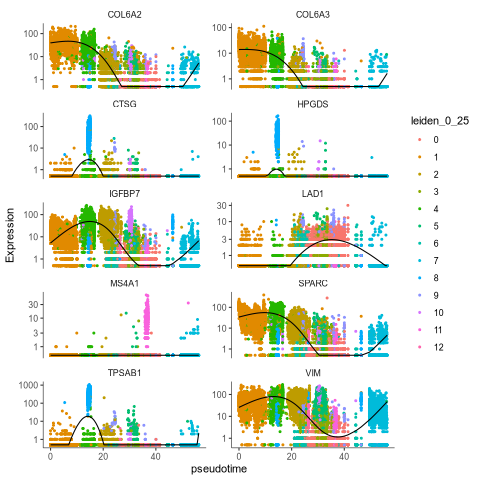

In [62]:
%%R
library(dplyr)
library(ggplot2)
## 下面我们进行绘制单个基因在不同亚群之间的表达量变化
# 可以指定感兴趣的基因
# 这里就按照morans_I选择前十个基因

top10 <- subset_pr_test_res |> top_n(n=10, morans_I) |>
    pull(gene_short_name) |> as.character()

#绘图
p <- plot_genes_in_pseudotime(cds[top10,], color_cells_by="leiden_0_25", # 
                             min_expr=0.5, ncol = 2)

ggsave("monocle3-基因表达点线图.pdf",p)
p

Saving 6.67 x 6.67 in image


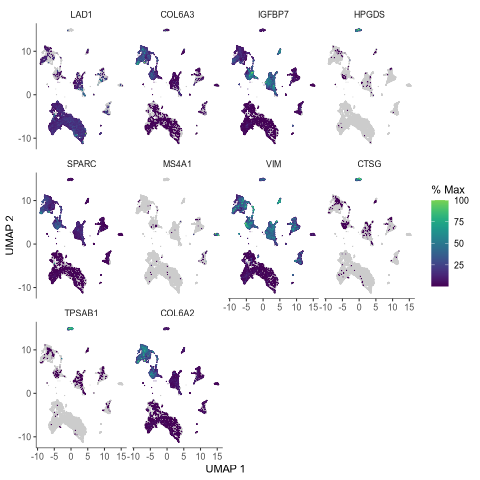

In [77]:
%%R
#基因特征图
p=plot_cells(cds, genes=top10, show_trajectory_graph=FALSE,label_cell_groups=FALSE,  label_leaves=FALSE)
ggsave("monocle3-基因表达聚类图.pdf",p)
p

In [72]:
%%R -o pseudotime

pseudotime <- colData(cds)$pseudotime

In [74]:
adata.obs["pseudotime"] = pseudotime  # type: ignore
adata.write(anndata_monocle3.h5ad)  # type: ignore